In [112]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import display
import math


## import and clean data

In [ ]:
data_df = pd.read_csv('voting_cadence_8_dropna.csv')
data_df.shape

In [115]:
#to do:
#basic analysis (number of votes, number of names)
    #top voters/ top missing - per person - DONE
    #voting homogeinity per club
    #pro / against gov (PIS)
    #top dissenters from club discipline    

#add more after cadence 7 is added
data_df.head(1)

,name,vote,cadence,club,voteId
0,Abramowicz Adam,Przeciw,8,PiS,46371


In [4]:
cols = data_df.columns
cols

Index(['Unnamed: 0', 'number', 'name', 'vote', 'cadence', 'club', 'voteId'], dtype='object')

In [5]:
#remove sloppy saved indexes
data_df = data_df.drop([cols[0],cols[1]],1)

In [6]:
data_df.reset_index() 
data_df.head()

,name,vote,cadence,club,voteId
0,Abramowicz Adam,Przeciw,8,PiS,46371
1,Andzel Waldemar,Przeciw,8,PiS,46371
2,Ardanowski Jan Krzysztof,Przeciw,8,PiS,46371
3,Ast Marek,Przeciw,8,PiS,46371
4,Babiarz Piotr Łukasz,Przeciw,8,PiS,46371


In [7]:
#quick summaries
result_set = set(data_df['vote'])
result_set

{'Nieobecny', 'Przeciw', 'Wstrzymał się', 'Za'}

## basic analysis (number of votes, number of names)

In [8]:
#checking if data makes sense - most people should have the same number of votes
people = data_df.groupby('name').count()
votes_cast = people['vote'].median()
print(votes_cast)

2579.0


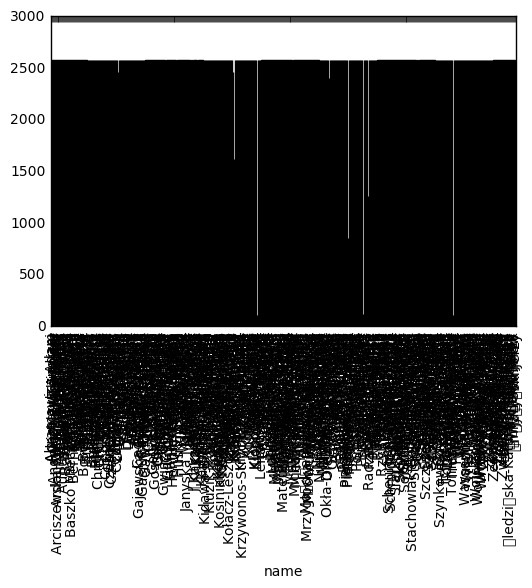

In [9]:
#seems that most people have the same number of votes which is correct
people['vote'].plot(kind='bar')

In [10]:
#get people with club affiliation
people_club = data_df.loc[:,['club','name']].drop_duplicates()

In [11]:
people_club.shape

(492, 2)

In [12]:
people_club.sort_values(by='club').head()


,club,name
6889,ED,Huskowski Stanisław
6890,ED,Niesiołowski Stefan
6891,ED,Kamiński Michał
6892,ED,Protasiewicz Jacek
1151022,Kukiz15,Sanocki Janusz


## top voters/ top missing - per person

In [13]:
# by person, group result set, calculate fraction of all votes, sort people
club_people = data_df.groupby(['club','name','vote']).count()

#convert index to columns
club_people.reset_index(level=club_people.index.names, inplace=True)

#drop useless column, change name
club_people.drop('voteId',1,inplace=True)
club_people.columns = ['club', 'name', 'vote', 'tally']
club_people.set_index(['club', 'name','vote'],inplace=True)

In [14]:
club_people.head()

tally
club name                vote                
ED   Huskowski Stanisław Nieobecny        230
                         Przeciw          107
                         Wstrzymał się      5
                         Za               179
     Kamiński Michał     Nieobecny        152

In [15]:
club_people.unstack()
club_people.reset_index(level=club_people.index.names, inplace=True)





In [16]:
club_people.head(10)

,club,name,vote,tally
0,ED,Huskowski Stanisław,Nieobecny,230
1,ED,Huskowski Stanisław,Przeciw,107
2,ED,Huskowski Stanisław,Wstrzymał się,5
3,ED,Huskowski Stanisław,Za,179
4,ED,Kamiński Michał,Nieobecny,152
5,ED,Kamiński Michał,Przeciw,130
6,ED,Kamiński Michał,Wstrzymał się,9
7,ED,Kamiński Michał,Za,230
8,ED,Niesiołowski Stefan,Nieobecny,46
9,ED,Niesiołowski Stefan,Przeciw,186


In [80]:
#sum of all possible votes
club_people_all = club_people.groupby(['club','name']).sum()

In [81]:
club_people_all.reset_index(level=club_people_all.index.names, inplace=True)
club_people_all.head()

,club,name,tally
0,ED,Huskowski Stanisław,521
1,ED,Kamiński Michał,521
2,ED,Niesiołowski Stefan,521
3,ED,Protasiewicz Jacek,521
4,Kukiz15,Andruszkiewicz Adam,2579


In [82]:
club_people_all.shape

(492, 3)

In [83]:
#sum of missing votes
club_people_missing = club_people[club_people['vote']=='Nieobecny']
club_people_missing.index = range(len(club_people_missing))


In [84]:
club_people_missing.head()

,club,name,vote,tally
0,ED,Huskowski Stanisław,Nieobecny,230
1,ED,Kamiński Michał,Nieobecny,152
2,ED,Niesiołowski Stefan,Nieobecny,46
3,ED,Protasiewicz Jacek,Nieobecny,282
4,Kukiz15,Andruszkiewicz Adam,Nieobecny,257


In [85]:
club_people_missing.shape

(485, 4)

In [86]:
# add the missing tally to club_people_all
club_people_all['missing_tally'] = club_people_missing['tally']

In [87]:
#set missing to 0 for all people who were never missing
club_people_all.loc[np.isnan(club_people_all['missing_tally']), 'missing_tally'] = 0

In [88]:
#check how many people changed clubs
club_people_all[club_people_all.duplicated('name', keep=False)].sort_values(by='name')


,club,name,tally,missing_tally
0,ED,Huskowski Stanisław,521,230.0
475,UED,Huskowski Stanisław,167,20.0
118,PO,Huskowski Stanisław,1753,115.0
483,niez.,Huskowski Stanisław,138,97.0
120,PO,Jaros Michał,1463,450.0
54,N,Jaros Michał,1116,162.0
1,ED,Kamiński Michał,521,152.0
122,PO,Kamiński Michał,1753,336.0
484,niez.,Kamiński Michał,138,86.0
476,UED,Kamiński Michał,167,17.0


In [78]:
#sum all votes per person regardless of club
people_all = club_people_all.groupby('name').sum()

In [89]:
# calculate missing votes % per person
people_all['missing_pct'] = people_all['missing_tally']/people_all['tally']


In [90]:
people_all.head()

,tally,missing_tally,missing_pct
name,,,
Abramowicz Adam,2579,199.0,0.077162
Adamczyk Andrzej,2579,6.0,0.002326
Ajchler Zbigniew,2579,38.0,0.014734
Andruszkiewicz Adam,2579,257.0,0.099651
Andzel Waldemar,2579,153.0,0.059325


In [93]:
workers = people_all.sort_values('missing_pct',axis=0, ascending=False)

In [98]:
#show top/bottom workers
display(workers.head(10))
display(workers.tail(10))

,tally,missing_tally,missing_pct
name,,,
Jasiński Wojciech,131,466.0,3.557252
Tomczykiewicz Tomasz,106,232.0,2.188679
Hoc Czesław,106,209.0,1.971698
Pszczółkowski Piotr,119,89.0,0.747899
Mordak Robert,2579,827.0,0.320667
Tyszka Stanisław,2579,816.0,0.316402
Żyżyński Jerzy,890,279.0,0.313483
Paszyk Krzysztof,2579,803.0,0.311361
Kropiwnicki Robert,2579,777.0,0.301280


,tally,missing_tally,missing_pct
name,,,
Janczyk Wiesław,2579,2.0,0.000775
Bogucki Jacek,2579,2.0,0.000775
Golińska Małgorzata,2579,1.0,0.000388
Polaczek Jerzy,2579,1.0,0.000388
Kurzępa Jacek,2579,1.0,0.000388
Piotrowicz Stanisław,2579,1.0,0.000388
Michałkiewicz Krzysztof,2579,1.0,0.000388
Soboń Artur,2579,1.0,0.000388
Kempa Beata,2579,1.0,0.000388


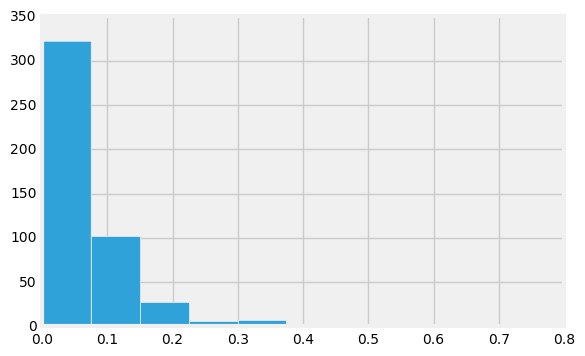

In [227]:
#plotting histogram zoomed on the 0%-100% missing votes range
workers.loc[workers['missing_pct']<1]['missing_pct'].hist()

## voting homogeinity

In [220]:
#for each voting session, check voting homogeinity within the club - median percent of majority vote
sessions_stacked = data_df.groupby(['voteId','club','vote']).count()
sessions_stacked.drop(sessions_stacked.columns[1],1, inplace=True)
sessions_stacked.columns = ['vote_count']

In [221]:
#sessions = sessions_stacked.unstack()
#sessions_stacked.unstack()
sessions_stacked.reset_index(sessions_stacked.index.names, inplace=True)

In [222]:
display(sessions_stacked.head())
display(sessions_stacked.shape)
display(sessions_stacked.columns)

,voteId,club,vote,vote_count
0,43802,Kukiz15,Nieobecny,10
1,43802,Kukiz15,Przeciw,1
2,43802,Kukiz15,Wstrzymał się,31
3,43802,N,Nieobecny,3
4,43802,N,Za,25


(38524, 4)

Index(['voteId', 'club', 'vote', 'vote_count'], dtype='object')

In [ ]:
#calculate per vote, per club: majority votes, total votes

(17523, 4)

In [149]:
sessions.head()

voteId     club vote_count                             
vote                  Nieobecny Przeciw Wstrzymał się     Za
0     43802  Kukiz15       10.0     1.0          31.0    0.0
1     43802        N        3.0     0.0           0.0   25.0
2     43802       PO        6.0     0.0           0.0  132.0
3     43802      PSL        0.0     0.0           0.0   16.0
4     43802      PiS        3.0   232.0           0.0    0.0